# EECE5644 Final Project
## Image Classification of Mars Curiosity Rover 
### Ethan Holand and Jarrod Homer
***

In [351]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

# from torchsampler import ImbalancedDatasetSampler

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
random_seed = 7
np.random.seed(random_seed)
torch.manual_seed(random_seed)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [352]:
# Sets code to run on cpu or gpu, depending on what is available:
# In testing, GPU accel improves performance tenfold
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  37,    8,   12,   73,   31,  405,    5,   10, 1944,  239,  209,
         11,   48,   29,   84,   79,   30,  102,   16,   26,   46,  152,
        154,  558], dtype=int64))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23]), array([  9,   2,   3,  19,   8, 101,   1,   2, 486,  60,  52,   3,  12,
         7,  21,  20,   8,  26,   4,   6,  11,  38,  39, 140], dtype=int64))
ground inlet mahli cal target ground ground wheel ground ground


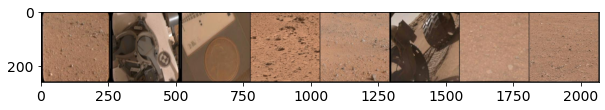

In [353]:
# Define how transform the data for processing in batches
transform = transforms.Compose([
        transforms.Resize([256,256]), # Resizing the image
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.0,0.0,0.0), std=(1.0,1.0,1.0)),
        # transforms.Grayscale() # Converting images to grayscale, helps with hyperspectral
    ])

# Specify the batch size for SGD
batch_size = 64
# Use the ImageFolder class, which is a generic dataloder useful when images stored in labelled directories
# Apply transform to images specified above, importantly converting "ToTensor"
# test_dataset= torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\test', transform=transform)
# train_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train', transform=transform)
# print("Dataset has {} training samples and {} test samples".format(len(train_dataset), len(test_dataset)))

dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\train_and_valid', transform=transform)
# test_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\test_split', transform=transform)


# Specify classes for convenience in printing
classes = ('apxs', 'apxs cal target', 'chemcam cal target', 'chemin inlet open', 'drill', 'drill holes', 'drt front', 'drt side', 'ground', 'horizon', 'inlet', 'mahli', 'mahli cal target', 'mastcam', 'mastcam cal target', 'observation tray', 'portion box', 'portion tube', 'portion tube opening', 'rems uv sensor', 'rover rear deck', 'scoop', 'turret', 'wheel')

# List of targets/labels for entire dataset
targets = dataset.targets
# Use sklearn function to split the data into training-test sets (80-20 split)
# Stratified ensures that same percentage of samples of each target class form a complete set
train_idx, test_idx= train_test_split(
    np.arange(len(targets)), test_size=0.2, random_state=random_seed, shuffle=True, stratify=targets)

# Printing the unique class labels in each split set and the number of occurrences per class
print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[test_idx], return_counts=True))

# Create training and test subsets based on split indices
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Define iterable for our newly created dataset and shuffle samples 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)


### Plotting stuff ###
fig = plt.figure(figsize=(10,15))
# Utility function to show an image
def imshow(img):
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0))) #CHW to HWC (channels, height, width)

# Get some random training dataset images
dataiter = iter(train_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:8]))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [354]:
# Code to find class weights. This could help the imbalanced dataset, but testing has shown otherwise
class_weights=class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(dataset.targets),y=dataset.targets)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights)

tensor([ 4.8786, 22.4417, 14.9611,  2.4393,  5.7543,  0.4435, 37.4028, 18.7014,
         0.0924,  0.7506,  0.8598, 16.0298,  3.7403,  6.2338,  2.1373,  2.2668,
         5.9057,  1.7533, 11.2208,  7.0130,  3.9371,  1.1811,  1.1628,  0.3215],
       device='cuda:0')


In [355]:
# Note that PyTorch uses NCHW (samples, channels, height, width) image format convention
class ConvNet(nn.Module):
    def __init__(self, in_channels, num_filters, out_classes, kernel_size=3):
        super().__init__()
        # Conv2D layer with 'same' padding so image retains shape
        self.conv1 = nn.Conv2d(in_channels, num_filters, kernel_size, padding='same')
        self.conv1_bn=nn.BatchNorm2d(num_filters) # NOTE New
        self.drop = nn.Dropout(p=0.2)
        #self.dropout = 
        # MaxPooling layer with 2x2 kernel size and stride 2
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, padding='same')
        self.conv2_bn=nn.BatchNorm2d(num_filters*2) # NOTE New

        self.fc1 = nn.Linear(num_filters*2*64*64, num_filters)
        self.fc2 = nn.Linear(num_filters, out_classes)

    def forward(self, x):
        x = x.to(device)
        # Non-linear ReLU activations between convolutional layers
        # Conv->ReLU->Pooling
        # 280x280 image -> 140x140 after pooling
        x = self.pool(self.drop(F.relu(self.conv1(x))))
        # 140x140 feature map -> 70x70 after pooling
        x = self.pool(self.drop(F.relu(self.conv2(x))))
        # Flatten all dimensions except batch (start_dim=1)
        x = torch.flatten(x, 1) # Prepares data from convolutional layers to fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

input_channels = images.shape[1] # 3 for RGB images or 1 for grayscale
model = ConvNet(input_channels, num_filters=32, out_classes=len(classes)).to(device)
summary(model, input_size=(input_channels, 256, 256))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─BatchNorm2d: 1-2                       128
├─Dropout: 1-3                           --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─BatchNorm2d: 1-6                       256
├─Linear: 1-7                            33,554,496
├─Linear: 1-8                            1,560
Total params: 33,632,088
Trainable params: 33,632,088
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,792
├─BatchNorm2d: 1-2                       128
├─Dropout: 1-3                           --
├─MaxPool2d: 1-4                         --
├─Conv2d: 1-5                            73,856
├─BatchNorm2d: 1-6                       256
├─Linear: 1-7                            33,554,496
├─Linear: 1-8                            1,560
Total params: 33,632,088
Trainable params: 33,632,088
Non-trainable params: 0

In [356]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train().to(device)
    for batch, (X, y) in enumerate(dataloader):
        X=X.to(device)
        y = y.to(device)
        # Compute prediction error
        predictions = model(X).to(device)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Report loss every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            predictions = model(X).to(device)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy
    
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to output
criterion = nn.CrossEntropyLoss(weight=class_weights)
num_epochs = 10
accuracies = np.zeros(num_epochs)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_train_loader(model, train_dataloader, criterion, optimizer)
    accuracies[t] = model_test_loader(model, test_dataloader, criterion)

Epoch 1
-------------------------------


RuntimeError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 8.00 GiB total capacity; 6.52 GiB already allocated; 0 bytes free; 7.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

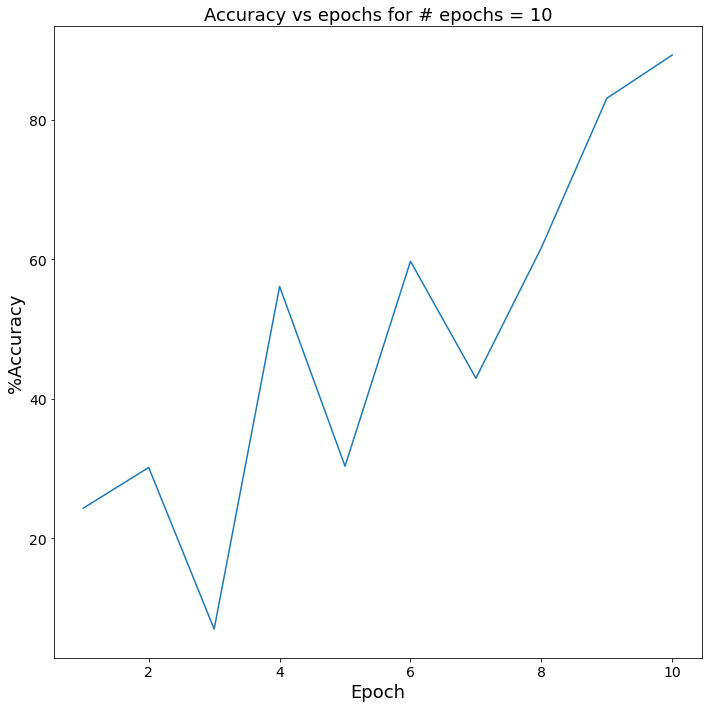

In [ ]:
# Plot accuracies over epochs:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, num_epochs+1), accuracies)
plt.title("Accuracy vs epochs for # epochs = {}".format(num_epochs))
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('%Accuracy')
plt.show()

GroundTruth:  ground scoop horizon inlet mastcam cal target wheel horizon ground drill holes wheel mastcam cal target ground wheel ground ground drill holes wheel inlet ground wheel ground ground wheel portion tube portion tube ground drill holes horizon drill holes wheel wheel drill holes ground wheel wheel ground drill holes portion box ground wheel rover rear deck ground ground ground ground ground wheel ground ground drill holes ground wheel inlet drill holes ground ground ground ground mahli wheel ground ground ground ground
Predicted:  ground scoop horizon inlet mastcam cal target wheel horizon ground drill holes wheel mastcam cal target horizon wheel ground ground drill holes wheel inlet ground wheel ground ground wheel portion tube portion tube ground drill holes horizon ground wheel wheel drill holes horizon wheel wheel ground drill holes scoop ground wheel rover rear deck ground ground chemcam cal target ground ground wheel ground ground drill holes ground wheel inlet drill h

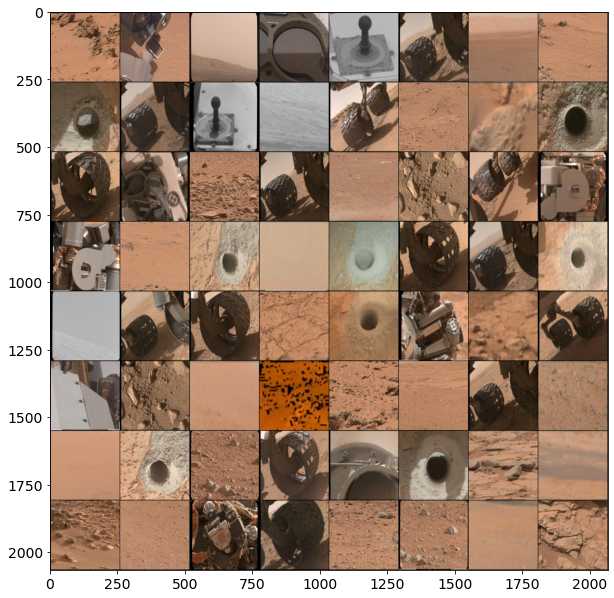

In [ ]:
### Plotting stuff ###
fig = plt.figure(figsize=(10,15))

# Get some random test dataset images
dataiter = iter(test_dataloader)
# Extract a batch
images, labels = dataiter.next()
# Show images
imshow(torchvision.utils.make_grid(images[:64]))
# Print labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

outputs = model(images).to(device)
# Argmax take the most probable class
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(64)))

tensor([ 8, 21,  9, 10, 14, 23,  9,  8,  5, 23, 14,  8, 23,  8,  8,  5, 23, 10,
         8, 23,  8,  8, 23, 17, 17,  8,  5,  9,  5, 23, 23,  5,  8, 23, 23,  8,
         5, 16,  8, 23, 20,  8,  8,  8,  8,  8, 23,  8,  8,  5,  8, 23, 10,  5,
         8,  8,  8,  8, 11, 23,  8,  8,  8,  8])


<AxesSubplot:>

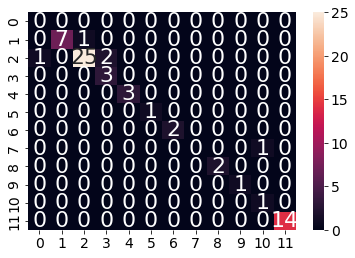

In [ ]:
print(labels)

cf_matrix = confusion_matrix(labels.to('cpu'), predicted.to('cpu'))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
final_test_dataset = torchvision.datasets.ImageFolder(root=r'C:\Users\ethan\OneDrive - Northeastern University\_Summer 2022\EECE5644 Machine Learning\EECE5644\Project\rearrangedFiles\test_split', transform=transform)
final_test_dataloader = DataLoader(final_test_dataset, batch_size=batch_size)
final_test_accuracy = model_test_loader(model, final_test_dataloader, criterion)
print(final_test_accuracy)

Test Error: 
 Accuracy: 47.4%, Avg loss: 2.977416 

tensor(47.4369, device='cuda:0')
